In [208]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import TUDataset
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader
import torch_geometric.nn as pyg_nn
import numpy as np

# 1.加载数据并理解数据集

In [13]:
# 加载Cora数据集.(自动帮你下载)
dataset = TUDataset(root='C:/Users/MI/Desktop/GCN/', name='ENZYMES')
dataset

Extracting C:\Users\MI\Desktop\GCN\ENZYMES\ENZYMES.zip
Processing...
Done!


ENZYMES(600)

In [102]:
dataset.num_features

3

In [103]:
dataset.num_classes

6

In [88]:
print(len(dataset))
data = dataset[0]
data
# edge_index代表的是边矩阵，是2行，74564列。x是特征矩阵，19580行，3列，说明有19580个node，y是标签。

600


Data(edge_index=[2, 168], x=[37, 3], y=[1])

In [89]:
# Node feature matrix with shape [num_nodes, num_node_features]
print(data.x)
print(data.x.shape)

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])
torch.Size([37, 3])


In [90]:
# Graph connectivity in COO format with shape [2, num_edges] and type torch.long
data.edge_index

tensor([[ 0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12,
         12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16,
         16, 16, 17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 20, 20,
         21, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25,
         25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28,
         28, 28, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 32,
         32, 32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 35, 35,
         35, 35, 36, 36, 36, 36],
        [ 1,  2,  3,  0,  2,  3, 24, 27,  0,  1,  3, 27, 28,  0,  1,  2,  4,  5,
         28,  3,  5,  6, 29,  3,  4,  6,  7, 29,  4,  5,  7,  8,  5,  6,  8,  9,
         10,  6,  7,  9,  7,  8, 10, 11, 12,  7,  9, 11, 12,  9, 10, 12, 26

In [91]:
# Edge feature matrix with shape [num_edges, num_edge_features]
# 这个是边的属性矩阵，类比点的属性矩阵
print(data.edge_attr)

None


In [92]:
# Target to train against (may have arbitrary shape), 
# e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]
print(data.y)
print(len(data.y))

tensor([5])
1


In [93]:
# Node position matrix with shape [num_nodes, num_dimensions]
print(data.pos)

None


None of these attributes is required. In fact, the Data object is not even restricted to these attributes. We can, e.g., extend it by data.face to save the connectivity of triangles from a 3D mesh in a tensor with shape [3, num_faces] and type torch.long.

In [94]:
edge,x,y = data  # 得到edge，node矩阵和y即label
print(edge,x,y)
numpyx = x[1].numpy()
numpyy = y[1].numpy()
numpyedge = edge[1].numpy()

('edge_index', tensor([[ 0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12,
         12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16,
         16, 16, 17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 20, 20,
         21, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25,
         25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28,
         28, 28, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 32,
         32, 32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 35, 35,
         35, 35, 36, 36, 36, 36],
        [ 1,  2,  3,  0,  2,  3, 24, 27,  0,  1,  3, 27, 28,  0,  1,  2,  4,  5,
         28,  3,  5,  6, 29,  3,  4,  6,  7, 29,  4,  5,  7,  8,  5,  6,  8,  9,
         10,  6,  7,  9,  7,  8, 10, 11, 12,  7,  9, 11, 12,

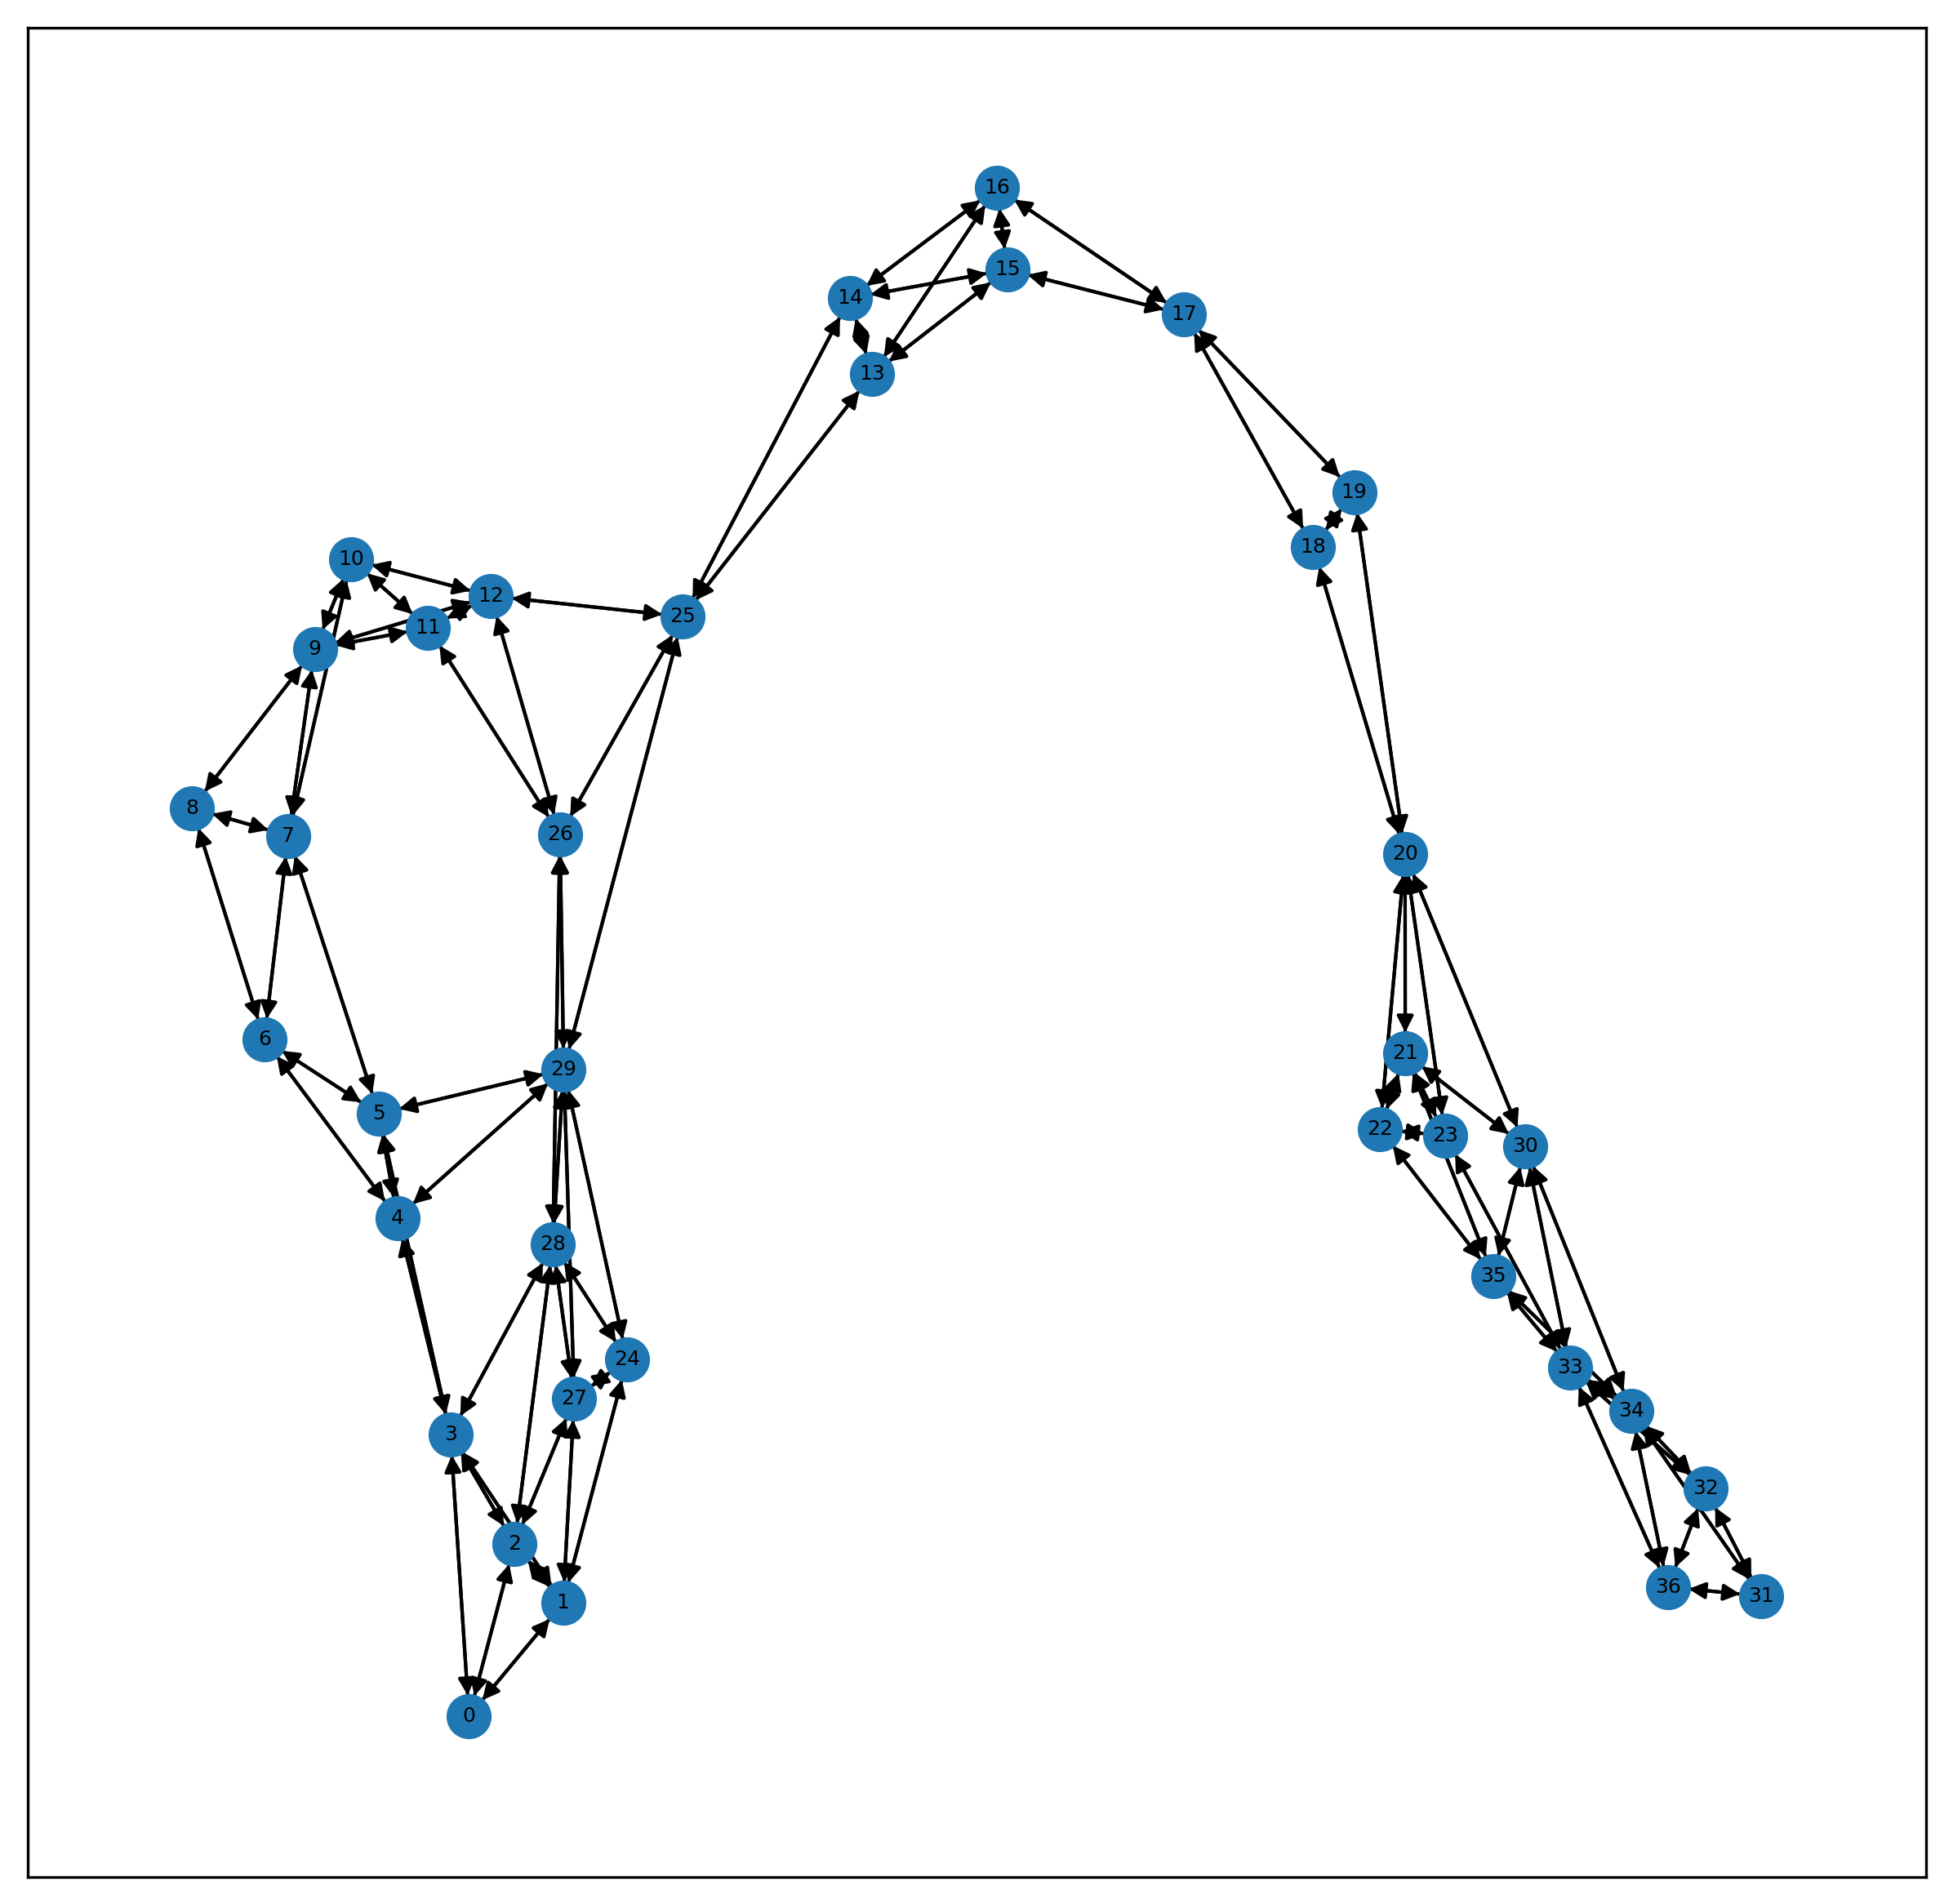

In [95]:
# 将整个数据集可视化出来
g = nx.DiGraph() # 建一个空的有向图
name,edgeinfo = edge
src = edgeinfo[0].numpy()
dst = edgeinfo[1].numpy()
edgelist = zip(src,dst)
for i,j in edgelist:
    g.add_edge(i,j) 
plt.rcParams['figure.dpi'] = 300 #分辨率
fig , ax1 = plt.subplots(figsize=(10,10))
nx.draw_networkx(g , ax = ax1 , font_size=6 , node_size = 150)
plt.show()

In [96]:
print(len(g.nodes))
g.nodes

37


NodeView((0, 1, 2, 3, 24, 27, 28, 4, 5, 6, 29, 7, 8, 9, 10, 11, 12, 26, 25, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 30, 35, 33, 34, 31, 32, 36))

# 2.构建GCN模型，以及训练和测试

In [117]:
dataset = dataset.shuffle()
train_dataset = dataset[:540]
test_dataset = dataset[540:]
len(train_dataset), len(test_dataset)

(540, 60)

In [186]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(3, 16)
        self.conv2 = GCNConv(16, 6)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
#         print(x.shape)
        x = pyg_nn.global_max_pool(x, batch)
#         print(x.shape)
        return F.log_softmax(x, dim=1)

In [251]:
# 训练
def train():
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
#         print(output.shape)
        label = data.y.to(device)
        loss = loss_f(output, label)
        loss.backward()
        loss_all += loss.item()
        optimizer.step()
        
    return (loss_all / len(train_dataset))
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_f = torch.nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)
for epoch in range(100):
    tmp = train()
    if epoch % 20 == 0:
        print(tmp) 

0.18143129525361237
0.1748289077370255
0.17250474073268748
0.1729406502511766
0.17272627706880922


In [252]:
# 测试
from  sklearn.metrics import accuracy_score
def evaluate(loader):
    model.eval()
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data).detach().numpy()
            label = data.y.detach().numpy()        
    return pred , label

loader = DataLoader(test_dataset, batch_size=60, shuffle=False)
pred , label = evaluate(loader)
print(pred.shape , label.shape)

(60, 6) (60,)


In [253]:
preds = []
# list_a.index(max(list_a)) 
for i in range(pred.shape[0]):
    tmp = pred[i].tolist()
    preds.append(tmp.index(max(tmp)))
len(preds)

60

In [254]:
accuracy_score(label, preds)

0.2833333333333333